In [245]:
%load_ext autoreload
%autoreload 2
from pathlib import Path
import torch
from pydantic import (
    BaseModel,
    Field,
    annotated_types,
    parse_obj_as,
    validator,
    root_validator,
)
from typing import Annotated
import torchvision
import json
import torch.nn as nn
from torchvision.models.detection.faster_rcnn import (
    FastRCNNPredictor,
    fasterrcnn_resnet50_fpn,
)
from courtvision.data import CourtVisionDataset

from torchvision import datapoints

# dinov2_vits14 = torch.hub.load("facebookresearch/dinov2", "dinov2_vits14")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [247]:
from courtvision.data import PadelDataset

dataset_name = "project-1-at-2023-05-05-19-29-73700012"
with open(
    f"/Users/benjamindecharmoy/projects/courtvision/datasets/annotations/{dataset_name}.json",
    "r",
) as fp:
    padel_dataset = PadelDataset(samples=json.load(fp))

In [248]:
root = "/Users/benjamindecharmoy/projects/courtvision/data/frames"
courtvision_dataset = CourtVisionDataset(dataset=padel_dataset, root=root)
print(f"{len(courtvision_dataset)=}")

len(courtvision_dataset)=80


torch.Size([1, 1, 4])


80

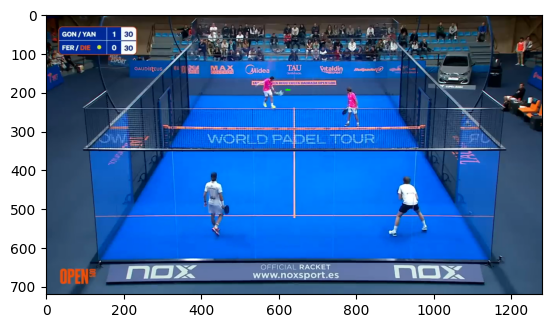

In [249]:
sample, image = courtvision_dataset[2]
CourtVisionDataset.show_sample(annotation=sample.annotations, image=image)
len(courtvision_dataset)

In [250]:
from courtvision.models import get_fasterrcnn_ball_detection_model

model_path = Path(
    "/Users/benjamindecharmoy/projects/courtvision/models/ball_detector/fasterrcnn_resnet50_fpn_project-1-at-2023-05-05-03-25-2cd00928.pt"
)
model_name = f"fasterrcnn_resnet50_fpn_{dataset_name}"
model = get_fasterrcnn_ball_detection_model(model_path=model_path)
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [251]:
annotated_sample, image = courtvision_dataset[0]
from courtvision.data import annotations_to_bbox, collate_fn

annotations_to_bbox(annotated_sample.annotations)

tensor([[603.1902, 189.5065, 613.4025, 194.0548]])

In [252]:
courtvision_dataloader = torch.utils.data.DataLoader(
    courtvision_dataset,
    batch_size=2,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn,
)

In [253]:
for (targets, images) in courtvision_dataloader:
    # print(images[0].shape)
    pass

    # image_dd = draw_bounding_boxes(
    #     torch.tensor(images[0].squeeze(0) * 255.0, dtype=torch.uint8),
    #     targets[0]["boxes"],
    # )
    # plt.imshow(image_dd.permute(1, 2, 0))
    # plt.show()
    # print(targets["boxes"].shape)
    # boxes = targets["boxes"]
    # assert len(boxes.shape) == 2 and boxes.shape[-1] == 4
    # print(images.shape)

In [254]:
def train_one_epoch(
    model, optimizer, data_loader, device, epoch, print_freq, scaler=None
):
    model.train()
    # metric_logger = utils.MetricLogger(delimiter="  ")
    # metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for (
        targets,
        images,
    ) in data_loader:  # metric_logger.log_every(data_loader, print_freq, header):
        # images = list(image.to(device) for image in images)
        # targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        # print(targets.shape)
        # print(targets)
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            # print(losses)

        print(loss_dict)
        # reduce losses over all GPUs for logging purposes
        # loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict.values())

        loss_value = losses_reduced.item()
        import math

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict)
            import sys

            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        # metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        # metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    # return metric_logger

In [255]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it for 10 epochs
num_epochs = 100
device = "cpu"
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    print(f"Epoch {epoch} of {num_epochs}")
    train_one_epoch(
        model, optimizer, courtvision_dataloader, device, epoch, print_freq=10
    )
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    # evaluate(model, data_loader_test, device=device)

Epoch 0 of 100
{'loss_classifier': tensor(0.0546, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0516, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0131, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0329, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0225, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0531, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0065, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0607, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0247, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0512, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0048, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0368, grad_fn=<DivBackward0>)}
{'loss_classifier': tensor(0.0151, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0393, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0039, grad_fn=<BinaryCrossEntropyWithLogitsBa

KeyboardInterrupt: 

In [219]:
with torch.no_grad():
    # fast_model.backbone.body = nn.Sequential(*[patch_embed, *mod_list[:]])
    # fast_model.roi_heads.box_predictor = head
    model.eval()
    out = model(image)

In [221]:
torch.save(
    model.state_dict(),
    f"/Users/benjamindecharmoy/projects/courtvision/models/ball_detector/{model_name}.pt",
)

/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_54775/2872721484.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(image.squeeze(0) * 255.0, dtype=torch.uint8), out[0]["boxes"], width=3


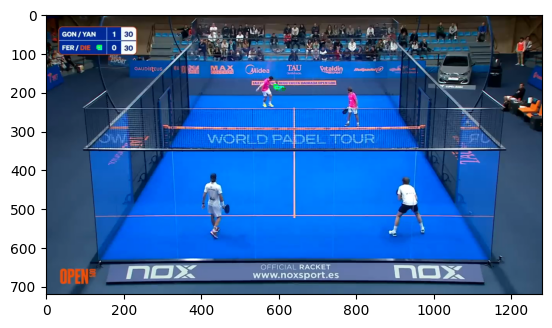

In [100]:
from torchvision.utils import draw_bounding_boxes

image_dd = draw_bounding_boxes(
    torch.tensor(image.squeeze(0) * 255.0, dtype=torch.uint8), out[0]["boxes"], width=3
)
from matplotlib import pyplot as plt

plt.imshow(image_dd.permute(1, 2, 0))

[{'boxes': tensor([[132.7517,  79.5820, 144.2173,  89.1404],
        [133.5488,  82.3853, 144.2331,  92.9684],
        [130.2062,  81.4318, 141.5005,  89.9317]]), 'labels': tensor([1, 1, 1]), 'scores': tensor([0.1531, 0.1081, 0.0696])}]


/var/folders/nv/c7kqzw0j08q0bg0fjbmbbr4w0000gn/T/ipykernel_54775/859595141.py:33: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(images[0].squeeze(0) * 255.0, dtype=torch.uint8),


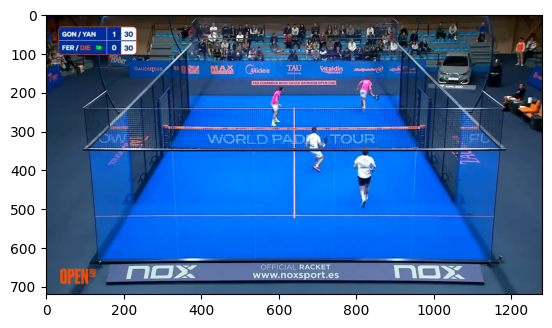

In [101]:
import os
from pathlib import Path
import random
from PIL import Image


class CourtvisionImageOnlyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        # self.dataset = dataset
        self.root = root
        self.dataset = sorted(Path(root).glob("*.png"))

    def __getitem__(self, idx):
        # sample = self.dataset[idx]
        idx = random.randint(0, len(self.dataset) - 1)
        image = Image.open(self.dataset[idx]).convert("RGB")
        image = torchvision.transforms.ToTensor()(image)
        return image

    def __len__(self):
        return len(self.dataset)


full_set = CourtvisionImageOnlyDataset(
    root="/Users/benjamindecharmoy/projects/courtvision/data/frames/curated_001"
)
for images in torch.utils.data.DataLoader(full_set, batch_size=1, shuffle=True):
    with torch.no_grad():
        model.eval()
        out = model(images)
        print(out)
    image_dd = draw_bounding_boxes(
        torch.tensor(images[0].squeeze(0) * 255.0, dtype=torch.uint8),
        out[0]["boxes"],
        width=3,
    )
    from matplotlib import pyplot as plt

    plt.imshow(image_dd.permute(1, 2, 0))
    plt.show()
    break

In [ ]:
rr.log_image("frame/test/img", image.squeeze(0).permute(1, 2, 0))
# out[0]["boxes"]

In [ ]:
dd = [box.tolist() for box in out[0]["boxes"]]
rr.log_rects("frame/boxes", dd, rect_format=RectFormat.XYXY)

In [ ]:
from rerun.components.rect2d import RectFormat

rr.log_rect("frame/box", out[0]["boxes"][2].tolist(), rect_format=RectFormat.XYXY)

In [ ]:
out[0]["boxes"][0].tolist()

[586.6439819335938, 360.8269348144531, 1062.5076904296875, 670.1864624023438]

In [ ]:
image.shape

torch.Size([1, 3, 720, 1280])

In [ ]:
out[0]

{'boxes': tensor([[ 586.6440,  360.8269, 1062.5077,  670.1865],
         [ 597.6040,  191.3133,  617.9384,  211.2779],
         [ 297.4283,  581.7656, 1115.0757,  708.7494],
         [ 389.4426,  128.8055,  970.5952,  490.9042],
         [ 434.5761,  284.2084,  946.3016,  621.3353],
         [ 761.4454,  195.3744,  802.9850,  293.6284],
         [ 428.8613,  451.5882,  473.8964,  573.3542],
         [ 821.0404,  284.2837, 1154.2217,  720.0000],
         [ 898.5524,  426.9127,  946.2028,  537.3666],
         [ 416.9436,  498.2014, 1103.0070,  664.2693],
         [ 878.7841,  415.2511,  968.8537,  574.6574],
         [ 757.9148,   17.3750,  977.1315,  369.8183],
         [ 763.1102,  232.0803,  817.0454,  287.9791],
         [ 573.9623,  174.1141,  595.5928,  222.5417],
         [ 588.5248,  189.3533,  609.8690,  209.1296],
         [ 406.5399,   64.9292,  815.7542,  349.9398],
         [ 471.6840,   19.7566,  897.4198,  720.0000],
         [1229.1489,  222.3493, 1280.0000,  271.0620],
 

In [ ]:
import label_studio

ModuleNotFoundError: No module named 'label_studio'